In [3]:
# ============================================================
# PARTIE 0 — Imports et paramètres généraux
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Proxies de marché :
# ^TNX : taux US 10 ans (rates)
# LQD  : crédit Investment Grade
# HYG  : crédit High Yield
tickers = ["^TNX", "LQD", "HYG"]

start_date = "2015-01-01"
end_date = None                 # None = jusqu'à aujourd'hui

rolling_window = 60             # 60 jours de bourse (~3 mois)
quantile_low = 0.05             # seuil bas pour définir un choc
quantile_high = 0.95            # seuil haut pour définir un choc

In [4]:
# PARTIE 1 — Téléchargement et nettoyage des données
# Téléchargement des données via Yahoo Finance
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

# On conserve uniquement les prix de clôture
# (pour plusieurs tickers, on obtient un MultiIndex)
prices = data["Close"].copy()

# Nettoyage :
# - suppression des lignes entièrement vides
# - propagation du dernier prix connu si une donnée manque
prices = prices.dropna(how="all")
prices = prices.ffill()

print("Dernières observations de prix :")
print(prices.tail())

Dernières observations de prix :
Ticker            HYG         LQD   ^TNX
Date                                    
2025-12-18  80.399002  110.413994  4.116
2025-12-19  80.360001  110.129997  4.151
2025-12-22  80.430000  110.110001  4.169
2025-12-23  80.489998  110.220001  4.169
2025-12-24  80.639999  110.650002  4.136


In [5]:
# PARTIE 2 — Calcul des rendements
# Rendements journaliers en pourcentage
# (choix volontairement simple, cohérent avec un projet FX)
returns = prices.pct_change().dropna()

print("\nStatistiques descriptives des rendements :")
print(returns.describe().T)


Statistiques descriptives des rendements :
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
HYG     2761.0  0.000187  0.005237 -0.054966 -0.001830  0.000252  0.002274   
LQD     2761.0  0.000123  0.005327 -0.050030 -0.002337  0.000345  0.002685   
^TNX    2761.0  0.000684  0.030084 -0.293201 -0.012515  0.000000  0.012763   

             max  
Ticker            
HYG     0.065460  
LQD     0.073918  
^TNX    0.498998  


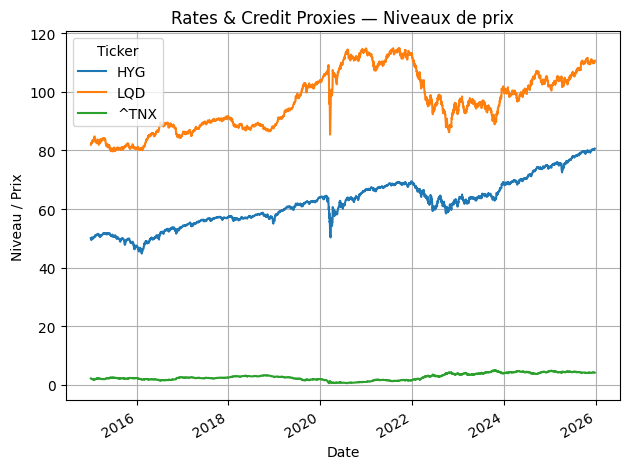

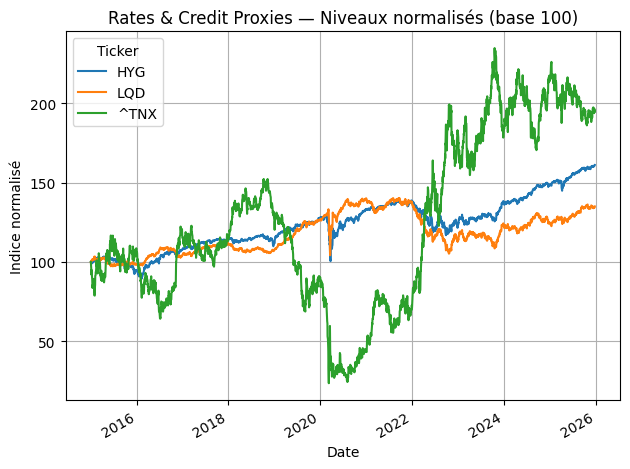

In [6]:
# PARTIE 3 — Graphiques des niveaux de prix
# 3.1 Niveaux bruts
prices.plot()
plt.title("Rates & Credit Proxies — Niveaux de prix")
plt.xlabel("Date")
plt.ylabel("Niveau / Prix")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3.2 Niveaux normalisés (base 100 au départ)
# Permet de comparer les dynamiques malgré des échelles différentes
normalized_prices = prices / prices.iloc[0] * 100

normalized_prices.plot()
plt.title("Rates & Credit Proxies — Niveaux normalisés (base 100)")
plt.xlabel("Date")
plt.ylabel("Indice normalisé")
plt.grid(True)
plt.tight_layout()
plt.show()

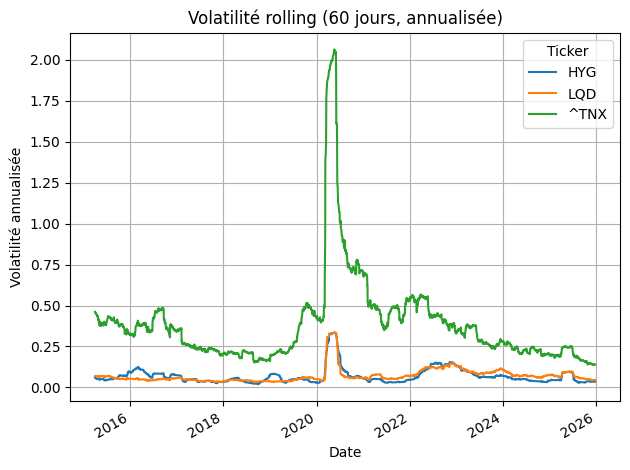


Matrice de corrélation :
Ticker       HYG       LQD      ^TNX
Ticker                              
HYG     1.000000  0.516762  0.096073
LQD     0.516762  1.000000 -0.534843
^TNX    0.096073 -0.534843  1.000000


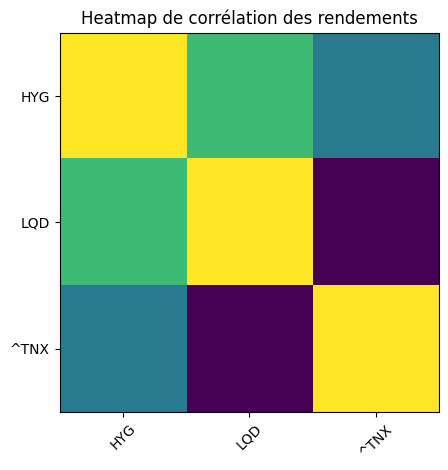

In [7]:
# PARTIE 4 — Volatilité rolling et corrélation
# Volatilité annualisée calculée sur une fenêtre glissante
rolling_vol = returns.rolling(rolling_window).std() * np.sqrt(252)

rolling_vol.plot()
plt.title(f"Volatilité rolling ({rolling_window} jours, annualisée)")
plt.xlabel("Date")
plt.ylabel("Volatilité annualisée")
plt.grid(True)
plt.tight_layout()
plt.show()

# Matrice de corrélation des rendements
corr_matrix = returns.corr()

print("\nMatrice de corrélation :")
print(corr_matrix)

# Heatmap simple de la corrélation
plt.imshow(corr_matrix.values)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Heatmap de corrélation des rendements")
plt.tight_layout()
plt.show()

In [8]:
# PARTIE 5 — Détection des chocs de marché
# Seuils empiriques basés sur les quantiles
quantiles = returns.quantile([quantile_low, quantile_high])

print("\nQuantiles utilisés pour la détection des chocs :")
print(quantiles)

# Un choc est défini comme un rendement très extrême
shock_mask = (
    (returns < quantiles.loc[quantile_low]) |
    (returns > quantiles.loc[quantile_high])
)

# Jour de choc système = au moins un actif en choc ce jour-là
system_shock_days = shock_mask.any(axis=1)

print("\nNombre total de jours de choc système :", int(system_shock_days.sum()))


Quantiles utilisés pour la détection des chocs :
Ticker       HYG       LQD      ^TNX
0.05   -0.006990 -0.007496 -0.036966
0.95    0.007277  0.006927  0.039437

Nombre total de jours de choc système : 574


In [9]:
# PARTIE 6 — Tableau de synthèse
summary_table = pd.DataFrame({
    "rendement_moyen_journalier": returns.mean(),
    "volatilite_annualisee": returns.std() * np.sqrt(252),
    "nombre_de_jours_de_choc": shock_mask.sum(),
    "pire_jour": returns.min(),
    "meilleur_jour": returns.max(),
})

print("\nTableau de synthèse :")
print(summary_table)


Tableau de synthèse :
        rendement_moyen_journalier  volatilite_annualisee  \
Ticker                                                      
HYG                       0.000187               0.083128   
LQD                       0.000123               0.084566   
^TNX                      0.000684               0.477561   

        nombre_de_jours_de_choc  pire_jour  meilleur_jour  
Ticker                                                     
HYG                         276  -0.054966       0.065460  
LQD                         276  -0.050030       0.073918  
^TNX                        276  -0.293201       0.498998  


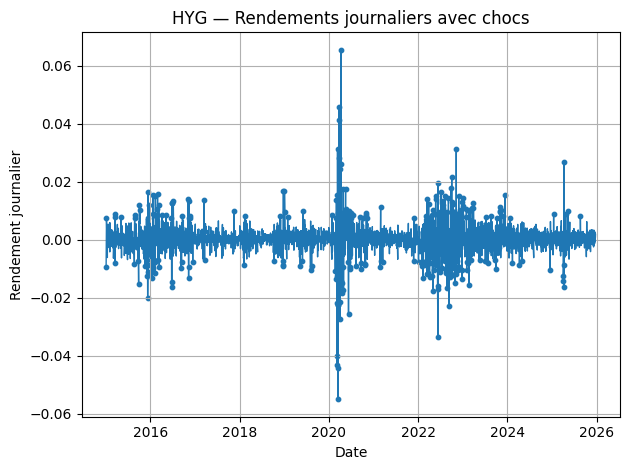

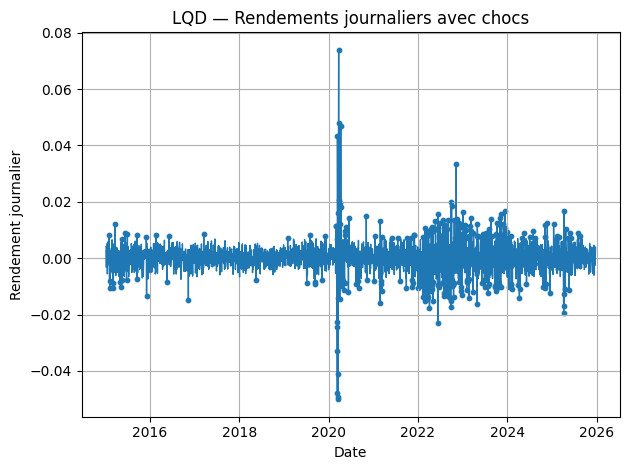

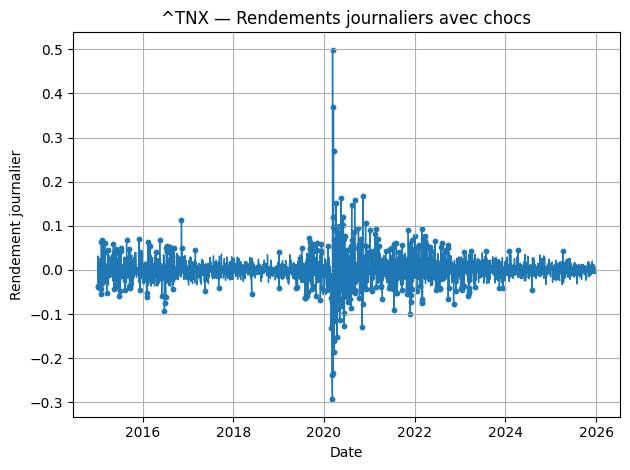

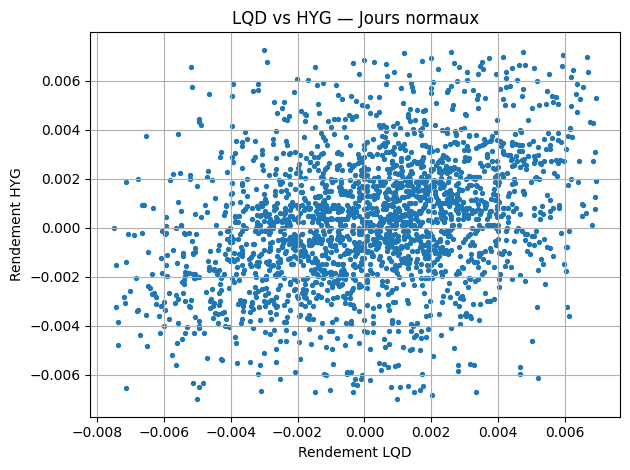

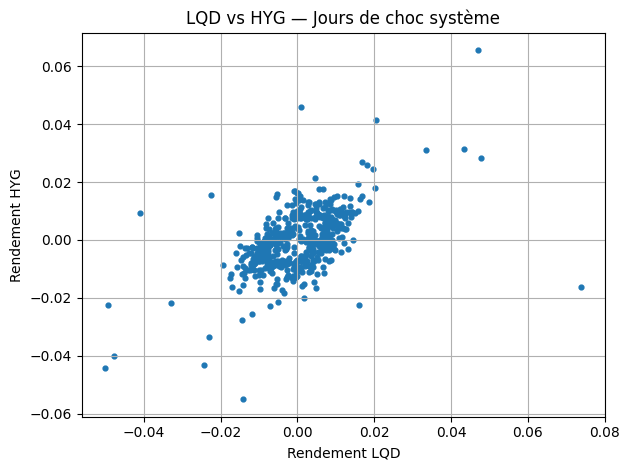

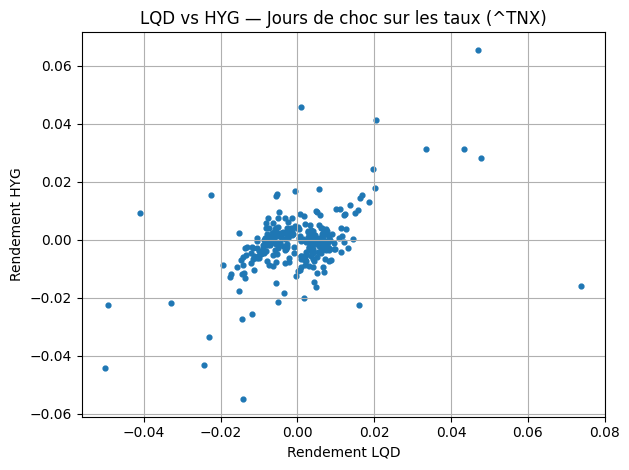

In [10]:
# PARTIE 7 — Graphiques focalisés sur les chocs
# 7.1 Rendements journaliers avec mise en évidence des chocs
for asset in returns.columns:
    plt.figure()
    plt.plot(returns.index, returns[asset], linewidth=1)
    plt.scatter(
        returns.index[shock_mask[asset]],
        returns.loc[shock_mask[asset], asset],
        s=10
    )
    plt.title(f"{asset} — Rendements journaliers avec chocs")
    plt.xlabel("Date")
    plt.ylabel("Rendement journalier")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7.2 Comparaison LQD vs HYG les jours normaux
plt.figure()
plt.scatter(
    returns.loc[~system_shock_days, "LQD"],
    returns.loc[~system_shock_days, "HYG"],
    s=8
)
plt.title("LQD vs HYG — Jours normaux")
plt.xlabel("Rendement LQD")
plt.ylabel("Rendement HYG")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.3 Comparaison LQD vs HYG les jours de choc système
plt.figure()
plt.scatter(
    returns.loc[system_shock_days, "LQD"],
    returns.loc[system_shock_days, "HYG"],
    s=12
)
plt.title("LQD vs HYG — Jours de choc système")
plt.xlabel("Rendement LQD")
plt.ylabel("Rendement HYG")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.4 Focus sur les chocs de taux (^TNX)
tnx_low = returns["^TNX"].quantile(quantile_low)
tnx_high = returns["^TNX"].quantile(quantile_high)

tnx_shock_days = (
    (returns["^TNX"] <= tnx_low) |
    (returns["^TNX"] >= tnx_high)
)

plt.figure()
plt.scatter(
    returns.loc[tnx_shock_days, "LQD"],
    returns.loc[tnx_shock_days, "HYG"],
    s=12
)
plt.title("LQD vs HYG — Jours de choc sur les taux (^TNX)")
plt.xlabel("Rendement LQD")
plt.ylabel("Rendement HYG")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:

# PARTIE 8 — Mini snapshot « daily report »
# Extraction des indicateurs pour la dernière date disponible
last_date = returns.index[-1]

daily_snapshot = pd.DataFrame({
    "dernier_rendement": returns.loc[last_date],
    "volatilite_rolling_annualisee": rolling_vol.loc[last_date],
    "choc_aujourdhui": shock_mask.loc[last_date],
})

print("\nSnapshot du dernier jour :", last_date.date())
print(daily_snapshot)


Snapshot du dernier jour : 2025-12-24
        dernier_rendement  volatilite_rolling_annualisee  choc_aujourdhui
Ticker                                                                   
HYG              0.001864                       0.034776            False
LQD              0.003901                       0.045092            False
^TNX            -0.007916                       0.138536            False
